In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
symsim_r1b1 = endoRNA(standardize=False)
symsim_r1b2 = endoATAC(standardize=False)

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 128,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b2_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 6, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["raw"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    
    DPT1 = torch.FloatTensor(DPT1).to(device)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 6, 
                                  use_potential = True)
    
    DPT2 = diff.DPT_similarity(data["raw"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    
    DPT2 = torch.FloatTensor(DPT2).to(device)

In [3]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 5e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 5e-4)

In [4]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, DPT, DPT2, optimizer_rna, optimizer_atac, optimizer_D, n_epochs=151, lamb_r = 1, lamb_d = 1)

epoch:  0 RNA loss: -0.59291, RNA recon loss: 0.33992, RNA dist loss: -0.93283 ATAC loss: 32.08182, ATAC recon loss: 33.08129, ATAC dist loss: -0.99947 Discriminator loss: 0.49322
epoch:  10 RNA loss: -0.72902, RNA recon loss: 0.21641, RNA dist loss: -0.94543 ATAC loss: 6.16975, ATAC recon loss: 7.16956, ATAC dist loss: -0.99981 Discriminator loss: 0.57888
epoch:  20 RNA loss: -0.78362, RNA recon loss: 0.16005, RNA dist loss: -0.94367 ATAC loss: 43.41304, ATAC recon loss: 44.41257, ATAC dist loss: -0.99952 Discriminator loss: 0.65815
epoch:  30 RNA loss: -0.80705, RNA recon loss: 0.15220, RNA dist loss: -0.95925 ATAC loss: 13.02072, ATAC recon loss: 14.02050, ATAC dist loss: -0.99978 Discriminator loss: 0.63042
epoch:  40 RNA loss: -0.82230, RNA recon loss: 0.13959, RNA dist loss: -0.96190 ATAC loss: -0.06113, ATAC recon loss: 0.93871, ATAC dist loss: -0.99985 Discriminator loss: 0.64056
epoch:  50 RNA loss: -0.79652, RNA recon loss: 0.15207, RNA dist loss: -0.94859 ATAC loss: 0.48403,

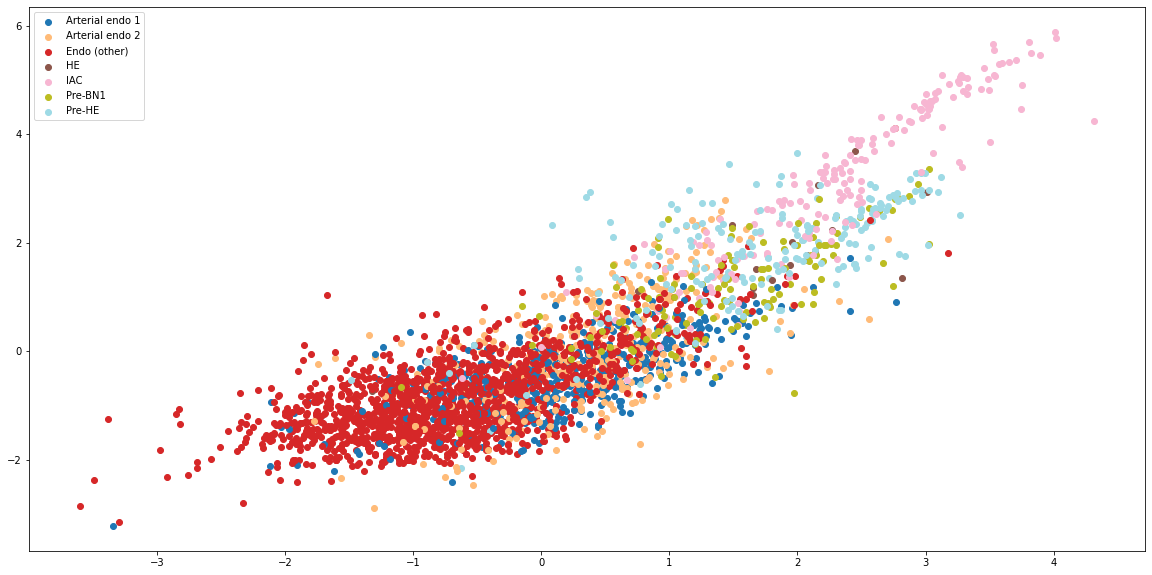

In [5]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)
# fig.savefig("./result/endo/phate_backbones.pdf")

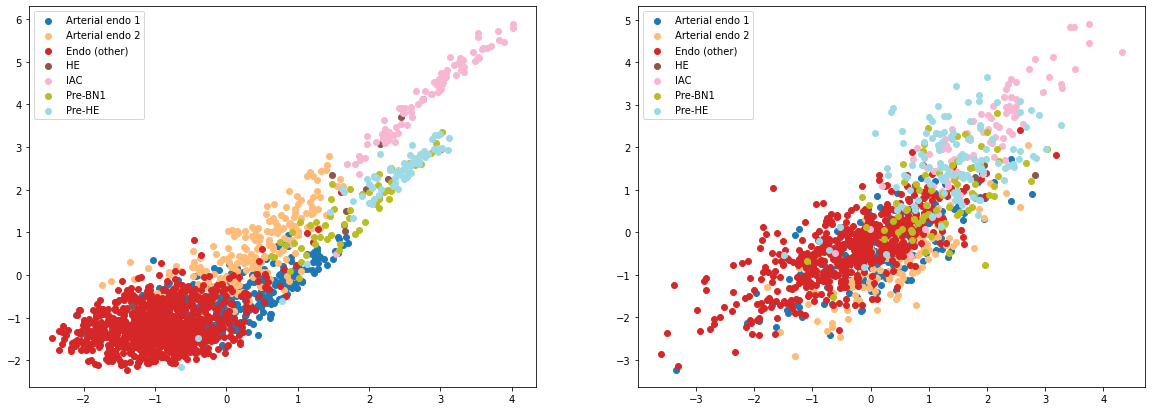

In [7]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1,2)

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[0].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)
axs[0].legend(cluster_types)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20",  cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[1].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

axs[1].legend(cluster_types)
# fig.savefig("./result/hm/3/phate_backbones_seperate_t6_1.pdf")

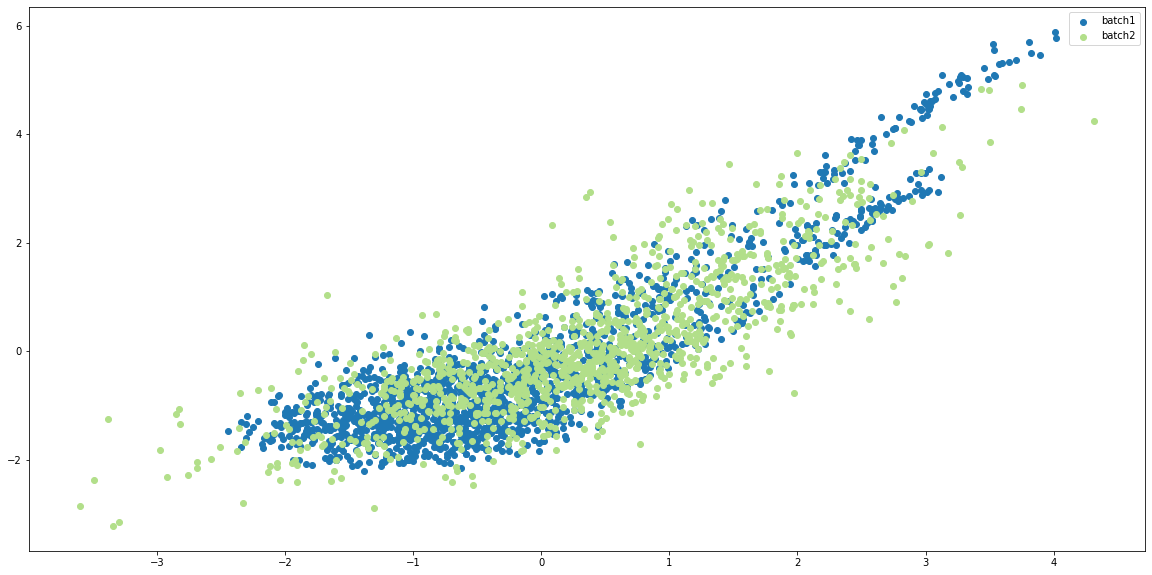

In [8]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
colormap = plt.cm.get_cmap("Paired")

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(1), label = "batch1", alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(2), label = "batch2", alpha = 1)

ax.legend()
# fig.savefig("./result/endo/phate_backbones_merge.pdf")